#
COMPLETE SUPERVISED EVALUATION FOR RADIO ASTRONOMY ANOMALY DETECTION
====================================================================
- Precision-Recall curves
- ROC curves  
- Cumulative detection plots
- Uses expert scores 4-5 as true anomalies


In [ ]:
# Install and import dependencies
!pip install scikit-learn pandas numpy matplotlib seaborn scipy -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication style
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'lines.linewidth': 2.5
})

print("Dependencies loaded successfully!")


Dependencies loaded successfully!


# STEP 1: UPLOAD DATA FILES

In [ ]:
from google.colab import files

print("\nUPLOAD REQUIRED FILE:")
print("1. reduced_features_evaluation_set.csv")
print()

uploaded = files.upload()


UPLOAD REQUIRED FILE:
1. reduced_features_evaluation_set.csv



Saving reduced_features_evaluation_set.csv to reduced_features_evaluation_set.csv


In [ ]:
from google.colab import files

print("\nUPLOAD REQUIRED FILE:")
print("2. protege_catalogue.csv")
print()

uploaded = files.upload()


UPLOAD REQUIRED FILE:
2. protege_catalogue.csv



Saving protege_catalogue.csv to protege_catalogue.csv


# STEP 2: ENHANCED ISOLATION FOREST CLASSES

In [ ]:
class EnhancedIsolationForest:
    """Enhanced Isolation Forest with various splitting strategies"""

    def __init__(self, n_estimators=100, contamination=0.1, split_method='standard',
                 scoring='depth', random_state=42):
        self.n_estimators = n_estimators
        self.contamination = contamination
        self.split_method = split_method
        self.scoring = scoring
        self.random_state = random_state
        self.trees = []

    def _calculate_feature_importance(self, X):
        variances = np.var(X, axis=0)
        kurtosis_vals = stats.kurtosis(X, axis=0)
        importance = (variances / np.sum(variances)) * 0.7 + \
                    (np.abs(kurtosis_vals) / np.sum(np.abs(kurtosis_vals))) * 0.3
        return importance / np.sum(importance)

    def _pooled_gain_split(self, X, feature_importance):
        feature = np.random.choice(X.shape[1], p=feature_importance)
        feature_values = X[:, feature]
        split_value = np.random.uniform(np.min(feature_values), np.max(feature_values))
        return feature, split_value

    def _kurtosis_split(self, X):
        kurtosis_vals = np.abs(stats.kurtosis(X, axis=0))
        kurtosis_probs = kurtosis_vals / np.sum(kurtosis_vals) + 1e-10
        kurtosis_probs = kurtosis_probs / np.sum(kurtosis_probs)
        feature = np.random.choice(X.shape[1], p=kurtosis_probs)
        feature_values = X[:, feature]
        split_value = np.random.uniform(np.min(feature_values), np.max(feature_values))
        return feature, split_value

    def _build_tree(self, X, max_depth=10, current_depth=0):
        if len(X) <= 1 or current_depth >= max_depth:
            return {'type': 'leaf', 'size': len(X), 'depth': current_depth}

        if self.split_method == 'pooled_gain':
            feature_importance = self._calculate_feature_importance(X)
            feature, split_value = self._pooled_gain_split(X, feature_importance)
        elif self.split_method == 'kurtosis':
            feature, split_value = self._kurtosis_split(X)
        else:  # standard
            feature = np.random.randint(0, X.shape[1])
            feature_values = X[:, feature]
            split_value = np.random.uniform(np.min(feature_values), np.max(feature_values))

        left_mask = X[:, feature] < split_value
        X_left = X[left_mask]
        X_right = X[~left_mask]

        if len(X_left) == 0 or len(X_right) == 0:
            return {'type': 'leaf', 'size': len(X), 'depth': current_depth}

        return {
            'type': 'internal',
            'feature': feature,
            'split_value': split_value,
            'left': self._build_tree(X_left, max_depth, current_depth + 1),
            'right': self._build_tree(X_right, max_depth, current_depth + 1)
        }

    def _path_length(self, x, tree, current_depth=0):
        if tree['type'] == 'leaf':
            size = tree['size']
            if size <= 1:
                return current_depth
            return current_depth + 2.0 * (np.log(size - 1) + 0.5772156649) - 2.0 * (size - 1) / size

        if x[tree['feature']] < tree['split_value']:
            return self._path_length(x, tree['left'], current_depth + 1)
        else:
            return self._path_length(x, tree['right'], current_depth + 1)

    def _hypervolume_score(self, x, tree):
        if tree['type'] == 'leaf':
            return 1.0 / (tree['size'] + 1)
        if x[tree['feature']] < tree['split_value']:
            return self._hypervolume_score(x, tree['left'])
        else:
            return self._hypervolume_score(x, tree['right'])

    def fit(self, X):
        np.random.seed(self.random_state)
        self.trees = []
        n_samples = X.shape[0]

        for i in range(self.n_estimators):
            sample_size = min(256, n_samples)
            sample_idx = np.random.choice(n_samples, sample_size, replace=False)
            X_sample = X[sample_idx]
            tree = self._build_tree(X_sample)
            self.trees.append(tree)

        return self

    def decision_function(self, X):
        scores = np.zeros(X.shape[0])

        for i, x in enumerate(X):
            if self.scoring == 'hypervolume':
                hypervolumes = [self._hypervolume_score(x, tree) for tree in self.trees]
                scores[i] = np.mean(hypervolumes)
            else:
                path_lengths = [self._path_length(x, tree) for tree in self.trees]
                avg_path_length = np.mean(path_lengths)
                c_n = 2.0 * (np.log(255) + 0.5772156649) - 2.0 * 255 / 256
                scores[i] = 2.0 ** (-avg_path_length / c_n)

        return -scores if self.scoring != 'hypervolume' else scores

print("Enhanced Isolation Forest classes loaded")


Enhanced Isolation Forest classes loaded


# STEP 3: LOAD AND MERGE DATA WITH EXPERT SCORES

In [ ]:
def load_data_with_expert_scores():
    """Load features and merge with expert scores"""

    print("\nLOADING DATA")
    print("=" * 40)

    # Load feature data
    features_df = pd.read_csv('reduced_features_evaluation_set.csv')
    print(f"Features loaded: {len(features_df)} sources")

    # Load protege catalogue with expert scores
    catalogue_df = pd.read_csv('protege_catalogue.csv')
    print(f"Catalogue loaded: {len(catalogue_df)} sources")

    # Merge on object ID
    merged_df = features_df.merge(
        catalogue_df[['objid', 'evaluation_subset_author_ML_score']],
        on='objid',
        how='left'
    )

    # Filter to evaluation subset (score != -1)
    eval_df = merged_df[merged_df['evaluation_subset_author_ML_score'] != -1].copy()

    print(f"Evaluation subset: {len(eval_df)} sources")

    # Extract data
    object_ids = eval_df['objid'].values
    expert_scores = eval_df['evaluation_subset_author_ML_score'].values
    feature_columns = [col for col in eval_df.columns if col not in ['objid', 'evaluation_subset_author_ML_score']]
    features = eval_df[feature_columns].values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    # Create binary labels: scores 4-5 = True anomalies
    true_labels = (expert_scores >= 4).astype(int)

    print("\nEXPERT SCORE DISTRIBUTION:")
    for score in [5, 4, 3, 2, 1]:
        count = np.sum(expert_scores == score)
        pct = (count / len(expert_scores)) * 100
        print(f"  Score {score}: {count:3d} sources ({pct:5.1f}%)")

    print(f"\nBINARY LABELS (scores >=4 = anomaly):")
    print(f"  True anomalies: {np.sum(true_labels)} ({np.sum(true_labels)/len(true_labels)*100:.1f}%)")
    print(f"  Normal sources: {len(true_labels) - np.sum(true_labels)}")

    return X, object_ids, true_labels, expert_scores

X, object_ids, true_labels, expert_scores = load_data_with_expert_scores()


LOADING DATA
Features loaded: 1031 sources
Catalogue loaded: 6161 sources
Evaluation subset: 1031 sources

EXPERT SCORE DISTRIBUTION:
  Score 5:  24 sources (  2.3%)
  Score 4:  62 sources (  6.0%)
  Score 3: 122 sources ( 11.8%)
  Score 2: 439 sources ( 42.6%)
  Score 1: 384 sources ( 37.2%)

BINARY LABELS (scores >=4 = anomaly):
  True anomalies: 86 (8.3%)
  Normal sources: 945


# STEP 4: TRAIN ALGORITHMS AND GET SCORES

In [ ]:
def train_algorithms(X):
    """Train all algorithm variants"""

    print("\nTRAINING ALGORITHMS")
    print("=" * 25)

    algorithms = {
        'Standard Enhanced': EnhancedIsolationForest(split_method='standard', random_state=42),
        'Pooled Gain': EnhancedIsolationForest(split_method='pooled_gain', random_state=42),
        'Kurtosis-based': EnhancedIsolationForest(split_method='kurtosis', random_state=42),
        'Hypervolume': EnhancedIsolationForest(scoring='hypervolume', random_state=42)
    }

    results = {}

    for name, alg in algorithms.items():
        print(f"  Training {name}...")
        alg.fit(X)
        scores = alg.decision_function(X)

        # For most algorithms, lower = more anomalous, so flip sign
        if name == 'Hypervolume':
            y_scores = scores  # Higher = more anomalous
        else:
            y_scores = -scores  # Flip so higher = more anomalous

        results[name] = {
            'model': alg,
            'scores': scores,
            'y_scores': y_scores  # For sklearn metrics
        }

    print("Training complete!")
    return results

results = train_algorithms(X)



TRAINING ALGORITHMS
  Training Standard Enhanced...
  Training Pooled Gain...
  Training Kurtosis-based...
  Training Hypervolume...
Training complete!


# STEP 5: CALCULATE METRICS

In [ ]:
def calculate_metrics(results, true_labels, object_ids):
    """Calculate PR curves, ROC curves, and cumulative metrics"""

    print("\nCALCULATING METRICS")
    print("=" * 20)

    eval_results = {}
    total_anomalies = np.sum(true_labels)

    for name, result in results.items():
        y_scores = result['y_scores']

        # Precision-Recall curve
        precision, recall, pr_thresholds = precision_recall_curve(true_labels, y_scores)
        avg_precision = average_precision_score(true_labels, y_scores)

        # ROC curve
        fpr, tpr, roc_thresholds = roc_curve(true_labels, y_scores)
        roc_auc = auc(fpr, tpr)

        # Sort by anomaly score (highest first)
        sorted_indices = np.argsort(y_scores)[::-1]
        sorted_labels = true_labels[sorted_indices]
        sorted_objects = object_ids[sorted_indices]

        # Cumulative true positives
        cumulative_tp = np.cumsum(sorted_labels)
        positions = np.arange(1, len(sorted_labels) + 1)

        # Precision at k
        p_at_10 = np.sum(sorted_labels[:10]) / 10 if len(sorted_labels) >= 10 else None
        p_at_50 = np.sum(sorted_labels[:50]) / 50 if len(sorted_labels) >= 50 else None
        p_at_100 = np.sum(sorted_labels[:100]) / 100 if len(sorted_labels) >= 100 else None

        eval_results[name] = {
            'precision': precision,
            'recall': recall,
            'avg_precision': avg_precision,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'cumulative_tp': cumulative_tp,
            'positions': positions,
            'sorted_labels': sorted_labels,
            'sorted_objects': sorted_objects,
            'p_at_10': p_at_10,
            'p_at_50': p_at_50,
            'p_at_100': p_at_100
        }

        print(f"{name}:")
        print(f"  Avg Precision: {avg_precision:.3f}")
        print(f"  ROC AUC: {roc_auc:.3f}")
        print(f"  P@10: {p_at_10:.3f}" if p_at_10 else "  P@10: N/A")
        print(f"  P@50: {p_at_50:.3f}" if p_at_50 else "  P@50: N/A")
        print()

    return eval_results

eval_results = calculate_metrics(results, true_labels, object_ids)


CALCULATING METRICS
Standard Enhanced:
  Avg Precision: 0.198
  ROC AUC: 0.677
  P@10: 0.400
  P@50: 0.320

Pooled Gain:
  Avg Precision: 0.201
  ROC AUC: 0.653
  P@10: 0.600
  P@50: 0.280

Kurtosis-based:
  Avg Precision: 0.155
  ROC AUC: 0.677
  P@10: 0.200
  P@50: 0.220

Hypervolume:
  Avg Precision: 0.184
  ROC AUC: 0.674
  P@10: 0.400
  P@50: 0.300



# STEP 6: CREATE FIGURES


GENERATING FIGURES


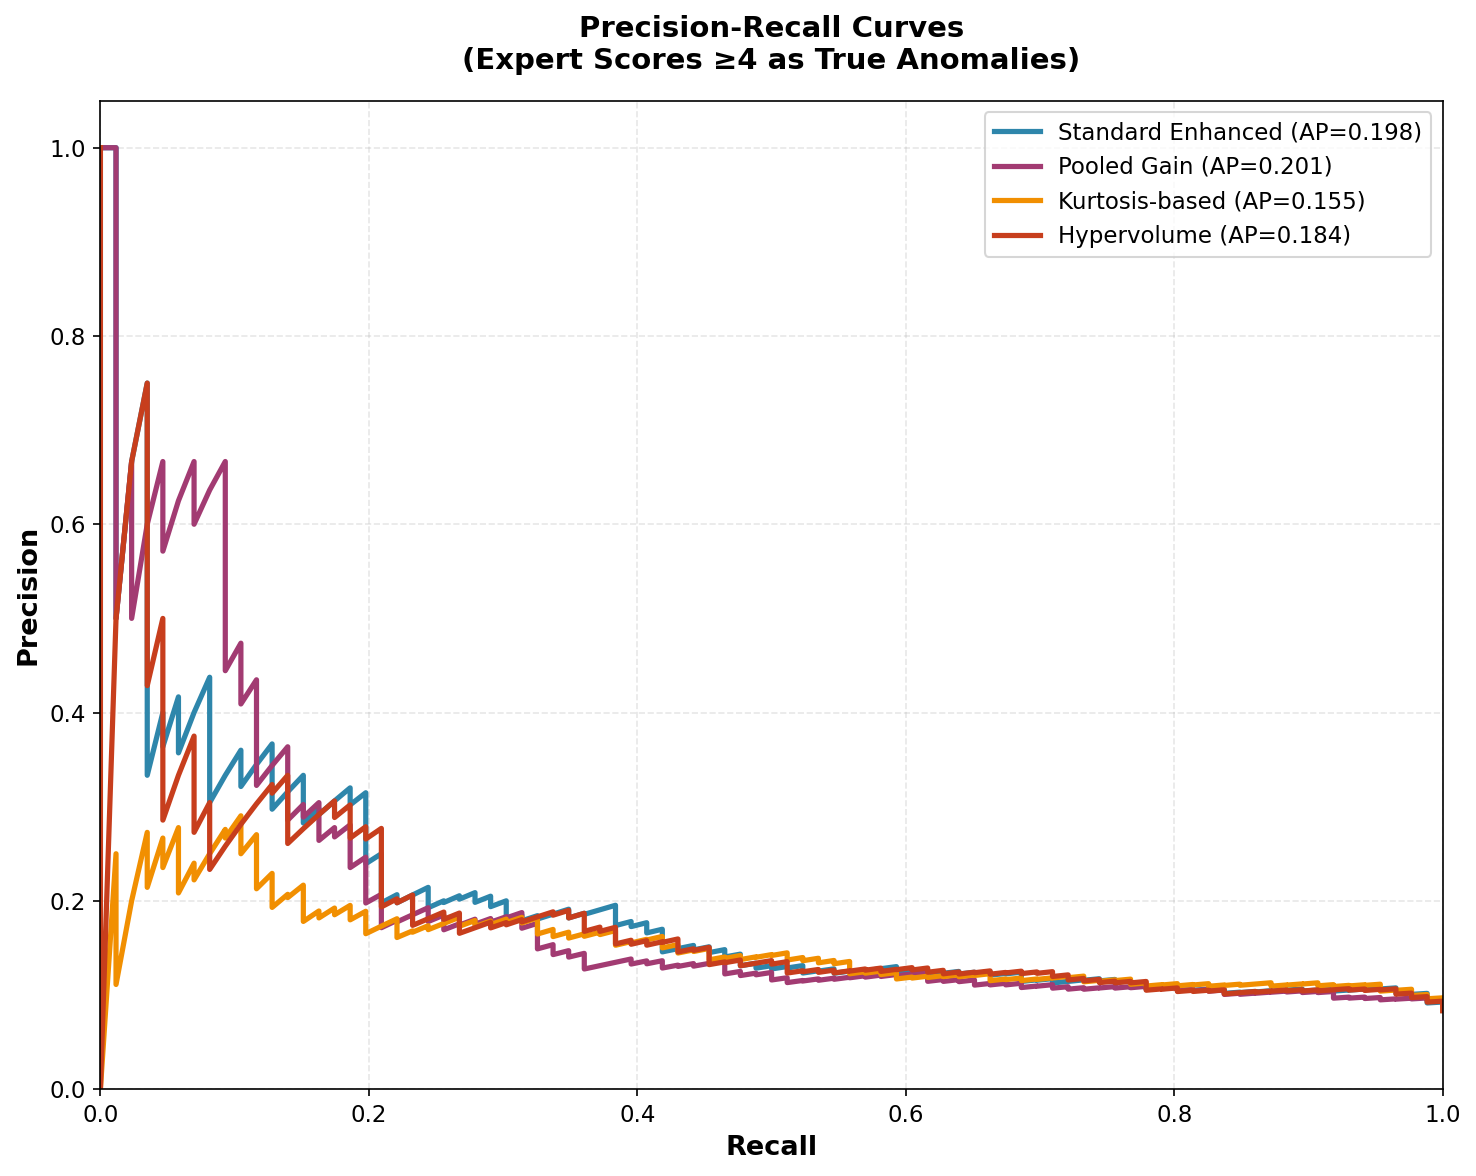

Saved: Figure_PR_Curves.png


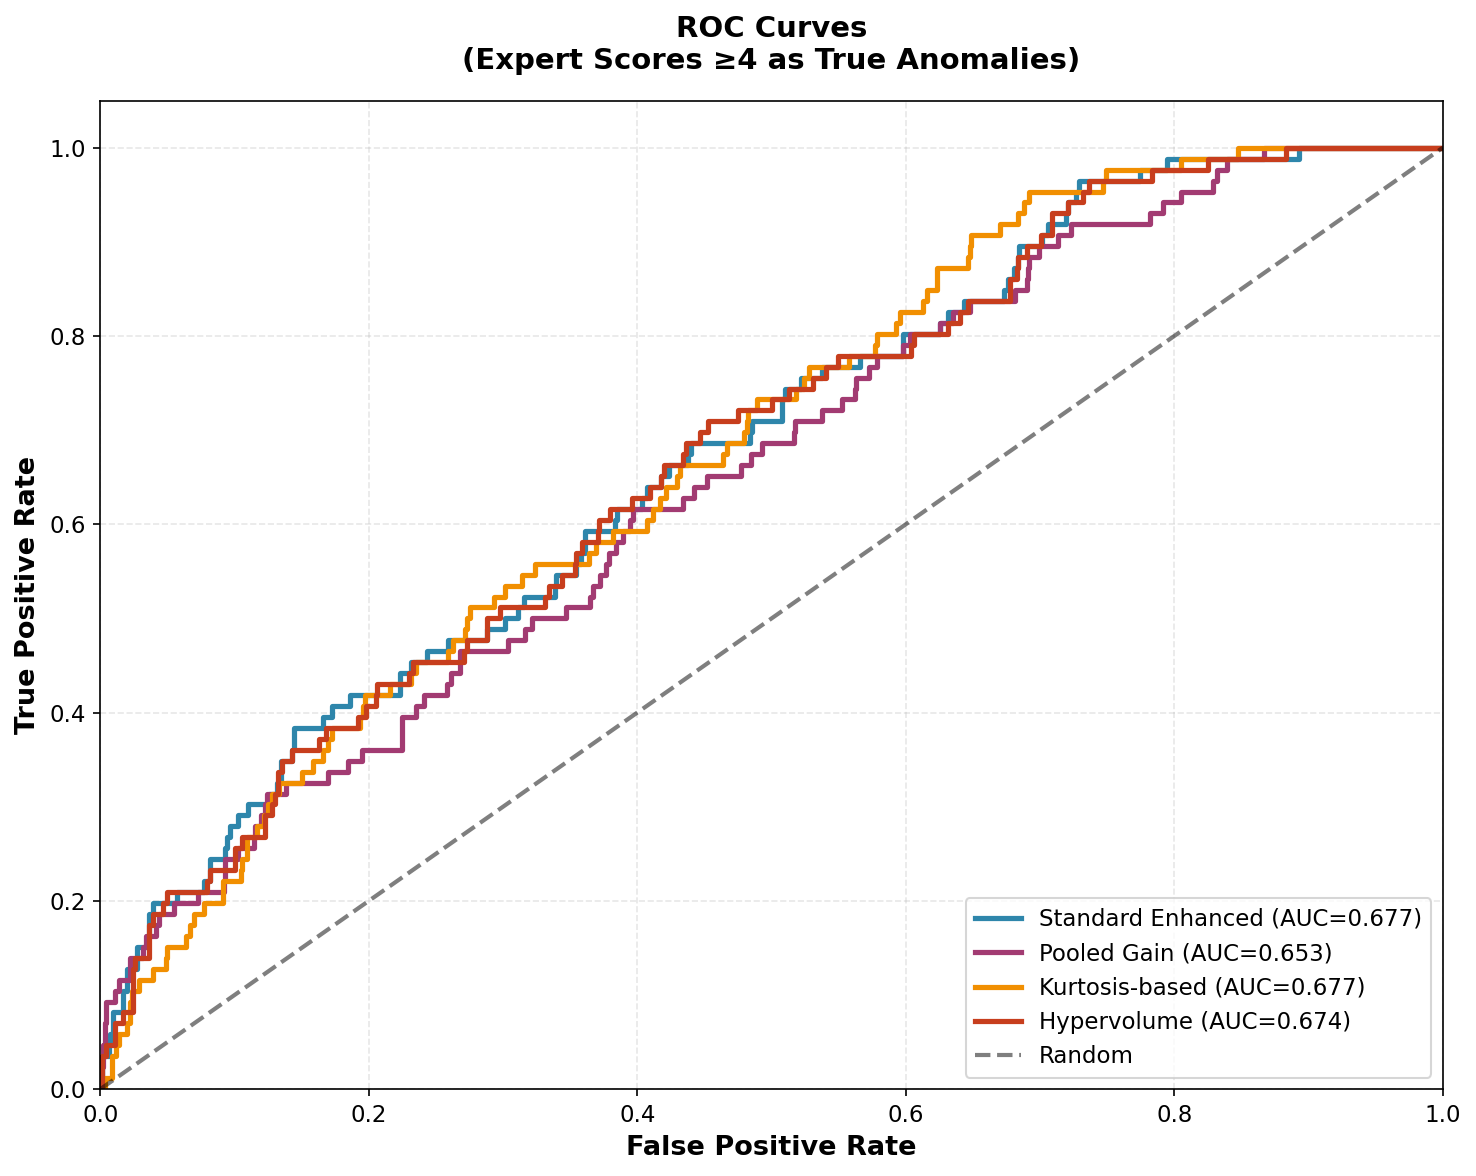

Saved: Figure_ROC_Curves.png


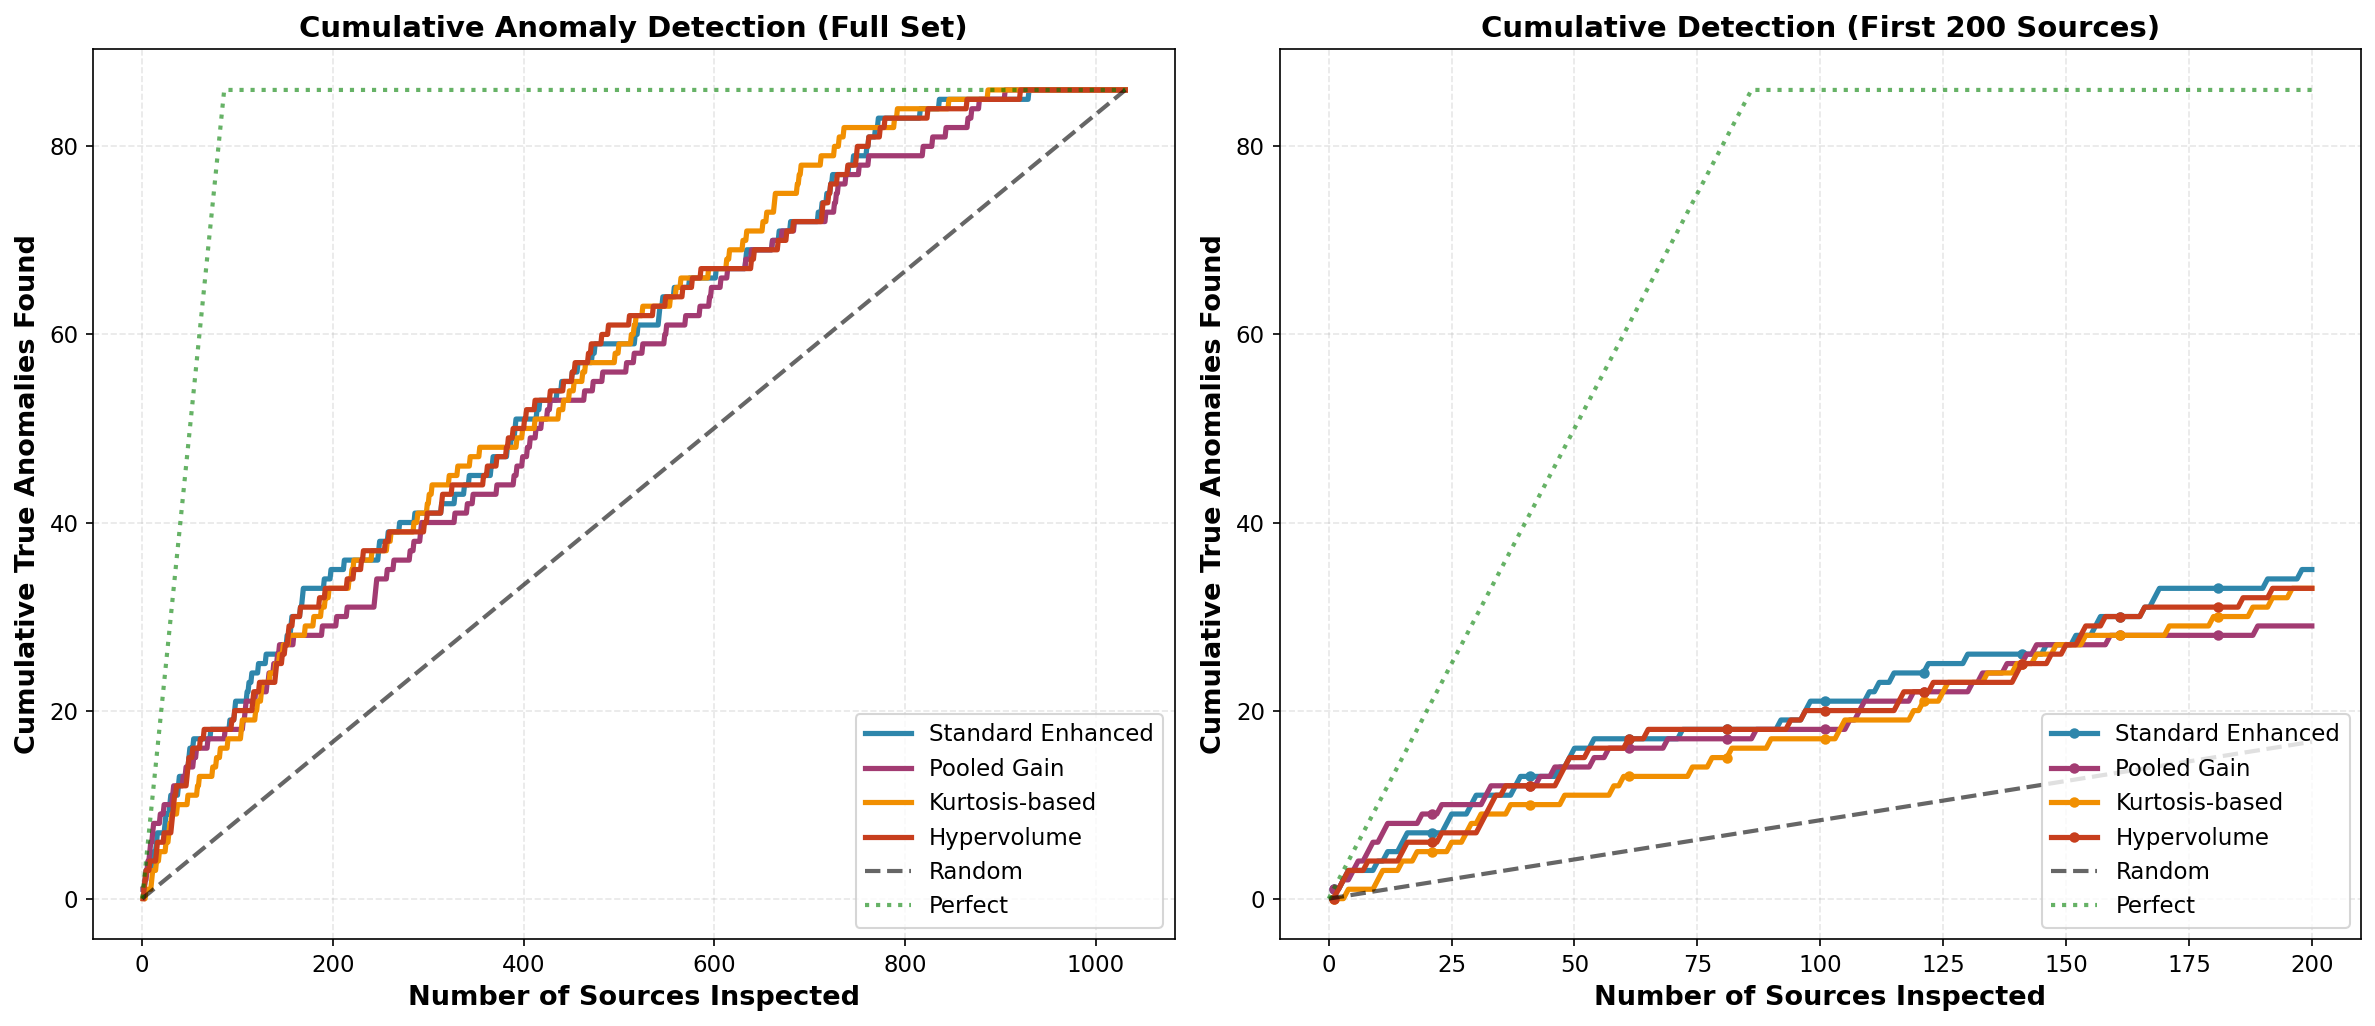

Saved: Figure_Cumulative_Detection.png


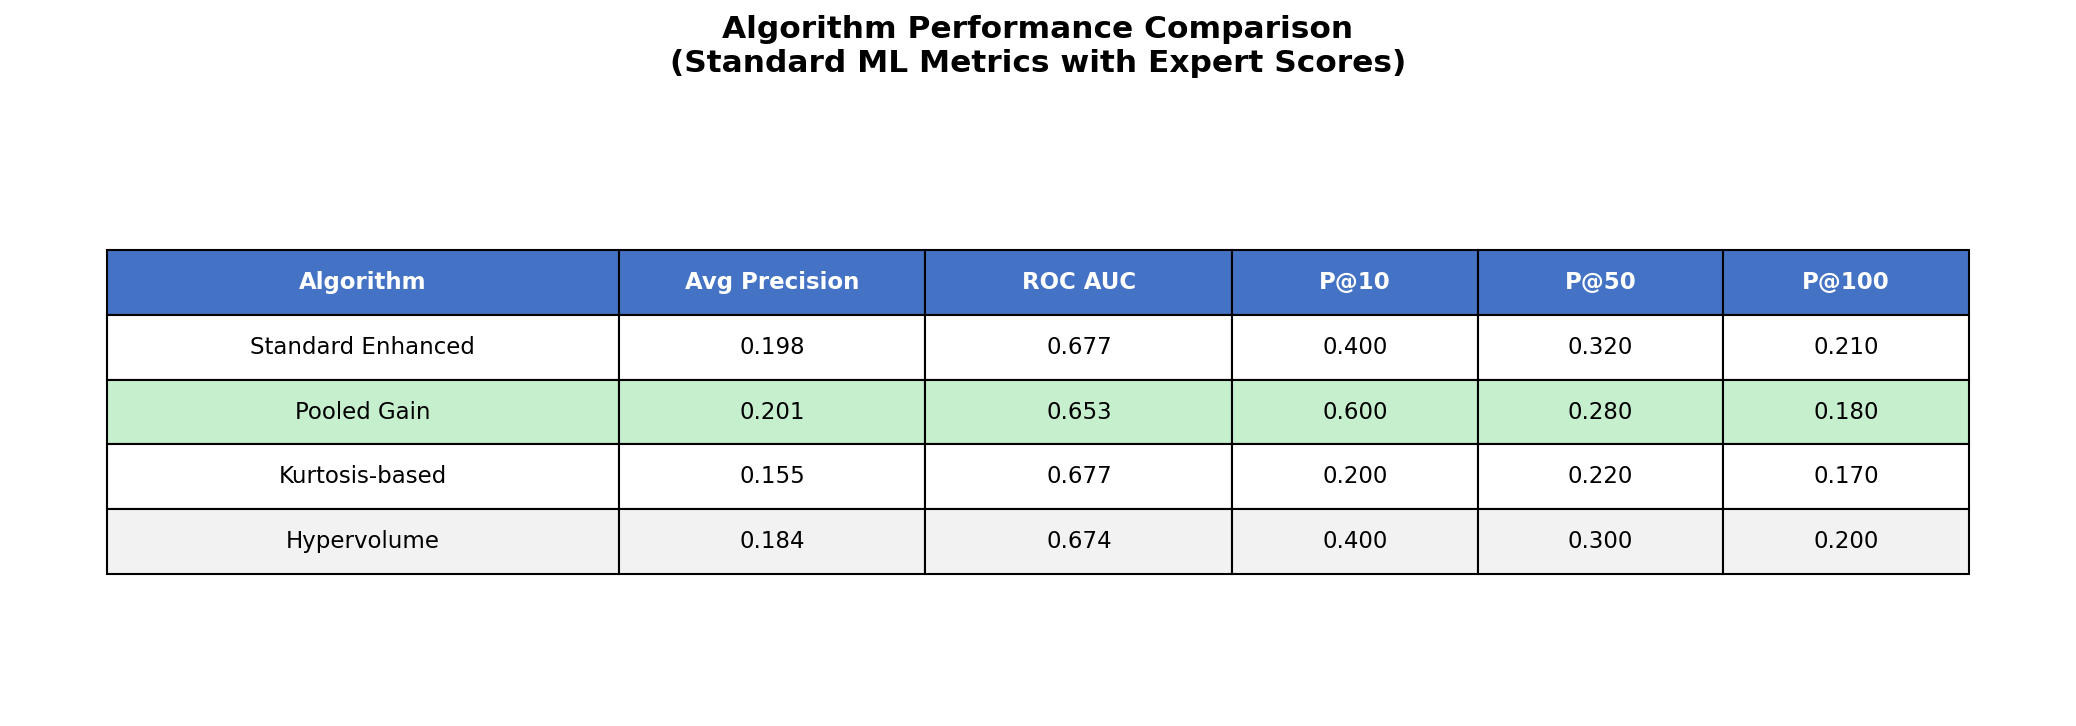

Saved: Figure_Performance_Table.png


In [ ]:
def create_precision_recall_figure(eval_results):
    """Precision-Recall curves"""

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

    for i, (name, result) in enumerate(eval_results.items()):
        ax.plot(result['recall'], result['precision'],
                color=colors[i], linewidth=2.5,
                label=f"{name} (AP={result['avg_precision']:.3f})")

    ax.set_xlabel('Recall', fontweight='bold')
    ax.set_ylabel('Precision', fontweight='bold')
    ax.set_title('Precision-Recall Curves\n(Expert Scores ≥4 as True Anomalies)',
                 fontweight='bold', pad=15)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.savefig('Figure_PR_Curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: Figure_PR_Curves.png")
    return fig

def create_roc_figure(eval_results):
    """ROC curves"""

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

    for i, (name, result) in enumerate(eval_results.items()):
        ax.plot(result['fpr'], result['tpr'],
                color=colors[i], linewidth=2.5,
                label=f"{name} (AUC={result['roc_auc']:.3f})")

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Random')

    ax.set_xlabel('False Positive Rate', fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontweight='bold')
    ax.set_title('ROC Curves\n(Expert Scores ≥4 as True Anomalies)',
                 fontweight='bold', pad=15)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.savefig('Figure_ROC_Curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: Figure_ROC_Curves.png")
    return fig

def create_cumulative_detection_figure(eval_results, true_labels):
    """Cumulative detection plot (Protege Figure 9 style)"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    total_anomalies = np.sum(true_labels)
    n_sources = len(true_labels)

    # Full plot
    for i, (name, result) in enumerate(eval_results.items()):
        ax1.plot(result['positions'], result['cumulative_tp'],
                color=colors[i], linewidth=2.5, label=name)

    ax1.plot([0, n_sources], [0, total_anomalies], 'k--', alpha=0.6, linewidth=2, label='Random')
    ax1.plot([0, total_anomalies, n_sources], [0, total_anomalies, total_anomalies],
             'g:', alpha=0.6, linewidth=2, label='Perfect')

    ax1.set_xlabel('Number of Sources Inspected', fontweight='bold')
    ax1.set_ylabel('Cumulative True Anomalies Found', fontweight='bold')
    ax1.set_title('Cumulative Anomaly Detection (Full Set)', fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3, linestyle='--')

    # Zoomed plot (first 200)
    zoom = 200
    for i, (name, result) in enumerate(eval_results.items()):
        ax2.plot(result['positions'][:zoom], result['cumulative_tp'][:zoom],
                color=colors[i], linewidth=2.5, label=name, marker='o',
                markersize=4, markevery=20)

    random_rate = total_anomalies / n_sources
    ax2.plot([0, zoom], [0, zoom * random_rate], 'k--', alpha=0.6, linewidth=2, label='Random')
    perfect_at_zoom = min(total_anomalies, zoom)
    ax2.plot([0, perfect_at_zoom, zoom], [0, perfect_at_zoom, perfect_at_zoom],
             'g:', alpha=0.6, linewidth=2, label='Perfect')

    ax2.set_xlabel('Number of Sources Inspected', fontweight='bold')
    ax2.set_ylabel('Cumulative True Anomalies Found', fontweight='bold')
    ax2.set_title(f'Cumulative Detection (First {zoom} Sources)', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('Figure_Cumulative_Detection.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: Figure_Cumulative_Detection.png")
    return fig

def create_performance_table(eval_results):
    """Performance comparison table"""

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.axis('off')

    table_data = []
    for name, result in eval_results.items():
        table_data.append([
            name,
            f"{result['avg_precision']:.3f}",
            f"{result['roc_auc']:.3f}",
            f"{result['p_at_10']:.3f}" if result['p_at_10'] else 'N/A',
            f"{result['p_at_50']:.3f}" if result['p_at_50'] else 'N/A',
            f"{result['p_at_100']:.3f}" if result['p_at_100'] else 'N/A'
        ])

    table = ax.table(
        cellText=table_data,
        colLabels=['Algorithm', 'Avg Precision', 'ROC AUC', 'P@10', 'P@50', 'P@100'],
        cellLoc='center',
        loc='center',
        colWidths=[0.25, 0.15, 0.15, 0.12, 0.12, 0.12]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)

    for i in range(6):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    for i in range(1, len(table_data) + 1):
        for j in range(6):
            table[(i, j)].set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')

    # Highlight best AP
    ap_values = [float(row[1]) for row in table_data]
    best_idx = np.argmax(ap_values)
    for j in range(6):
        table[(best_idx + 1, j)].set_facecolor('#C6EFCE')

    ax.set_title('Algorithm Performance Comparison\n(Standard ML Metrics with Expert Scores)',
                 fontweight='bold', fontsize=15, pad=20)

    plt.tight_layout()
    plt.savefig('Figure_Performance_Table.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: Figure_Performance_Table.png")
    return fig

# Generate all figures
print("\nGENERATING FIGURES")
print("=" * 20)

fig_pr = create_precision_recall_figure(eval_results)
fig_roc = create_roc_figure(eval_results)
fig_cum = create_cumulative_detection_figure(eval_results, true_labels)
fig_table = create_performance_table(eval_results)

# STEP 7: SUMMARY AND EXPORT

In [ ]:
print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)

best_alg = max(eval_results.items(), key=lambda x: x[1]['avg_precision'])
print(f"\nBest performing algorithm: {best_alg[0]}")
print(f"  Average Precision: {best_alg[1]['avg_precision']:.3f}")
print(f"  ROC AUC: {best_alg[1]['roc_auc']:.3f}")

print("\nGenerated figures:")
print("  - Figure_PR_Curves.png")
print("  - Figure_ROC_Curves.png")
print("  - Figure_Cumulative_Detection.png")
print("  - Figure_Performance_Table.png")

print("\nThese results address ")
print("   Precision-Recall curves with standard ML metrics")
print("  ROC curves for algorithm comparison")
print("   Cumulative detection plot (Protege Figure 9 style)")
print("   Expert scores (≥4) used as ground truth")
print("   Quantitative performance metrics")

files.download('Figure_PR_Curves.png')
files.download('Figure_ROC_Curves.png')
files.download('Figure_Cumulative_Detection.png')
files.download('Figure_Performance_Table.png')

print("\nAll figures downloaded!")


EVALUATION COMPLETE

Best performing algorithm: Pooled Gain
  Average Precision: 0.201
  ROC AUC: 0.653

Generated figures:
  - Figure_PR_Curves.png
  - Figure_ROC_Curves.png
  - Figure_Cumulative_Detection.png
  - Figure_Performance_Table.png

These results address 
   Precision-Recall curves with standard ML metrics
  ROC curves for algorithm comparison
   Cumulative detection plot (Protege Figure 9 style)
   Expert scores (≥4) used as ground truth
   Quantitative performance metrics


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All figures downloaded!
